In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pmdarima import auto_arima
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import warnings
warnings.filterwarnings("ignore")

In [2]:
train = pd.read_csv('Monthly-train.csv')
test = pd.read_csv('Monthly-test.csv')
info = pd.read_csv('M4-info.csv')

print("Train shape:", train.shape)
print("Test shape:", test.shape)
print("Info shape:", info.shape)

info.head()

Train shape: (48000, 2795)
Test shape: (48000, 19)
Info shape: (100000, 6)


,M4id,category,Frequency,Horizon,SP,StartingDate
0,Y1,Macro,1,6,Yearly,01-01-79 12:00
1,Y2,Macro,1,6,Yearly,01-01-79 12:00
2,Y3,Macro,1,6,Yearly,01-01-79 12:00
3,Y4,Macro,1,6,Yearly,01-01-79 12:00
4,Y5,Macro,1,6,Yearly,01-01-79 12:00


In [3]:
info_monthly = info[info['Frequency'] == 12]

train = train[train['V1'].isin(info_monthly['M4id'])]
test = test[test['V1'].isin(info_monthly['M4id'])]

train_sample = train.head(50)
test_sample = test.head(50)
info_sample = info_monthly[info_monthly['M4id'].isin(train_sample['V1'])]

print("Selected series info:")
display(info_sample.head())

Selected series info:


,M4id,category,Frequency,Horizon,SP,StartingDate
47000,M1,Macro,12,18,Monthly,01-06-76 12:00
47001,M2,Macro,12,18,Monthly,01-06-76 12:00
47002,M3,Macro,12,18,Monthly,01-06-76 12:00
47003,M4,Macro,12,18,Monthly,01-09-08 12:00
47004,M5,Macro,12,18,Monthly,01-03-06 12:00


In [4]:
def smape(actual, forecast):
    return 100 * np.mean(2 * np.abs(forecast - actual) / (np.abs(actual) + np.abs(forecast)))

In [5]:
results = []

for i in range(len(train_sample)):
    series_id = train_sample.iloc[i, 0]
    series_values = train_sample.iloc[i, 1:].dropna().values
    test_values = test_sample.iloc[i, 1:].dropna().values
    
    # Naive forecast = last observed value repeated
    last_value = series_values[-1]
    naive_forecast = [last_value] * len(test_values)
    
    error = smape(test_values, naive_forecast)
    category = info_sample[info_sample['M4id'] == series_id]['category'].values[0]
    
    results.append([series_id, category, 'Naive', error])


In [6]:
for i in range(len(train_sample)):
    series_id = train_sample.iloc[i, 0]
    series_values = train_sample.iloc[i, 1:].dropna().values
    test_values = test_sample.iloc[i, 1:].dropna().values
    
    try:
        model = ExponentialSmoothing(series_values, trend='add', seasonal=None)
        model_fit = model.fit()
        forecast = model_fit.forecast(steps=len(test_values))
        error = smape(test_values, forecast)
        category = info_sample[info_sample['M4id'] == series_id]['category'].values[0]
        
        results.append([series_id, category, 'ETS', error])
    except:
        print(f"ETS failed for {series_id}")


In [7]:
for i in range(len(train_sample)):
    series_id = train_sample.iloc[i, 0]
    series_values = train_sample.iloc[i, 1:].dropna().values
    test_values = test_sample.iloc[i, 1:].dropna().values
    
    try:
        # Auto ARIMA chooses best p,d,q automatically
        model = auto_arima(series_values, seasonal=False, stepwise=True, suppress_warnings=True)
        forecast = model.predict(n_periods=len(test_values))
        error = smape(test_values, forecast)
        category = info_sample[info_sample['M4id'] == series_id]['category'].values[0]
        
        results.append([series_id, category, 'Auto ARIMA', error])
    except:
        print(f"Auto ARIMA failed for {series_id}")


Average sMAPE by Model:
Model
Auto ARIMA     9.425707
ETS           11.315915
Naive         10.723521
Name: sMAPE, dtype: float64


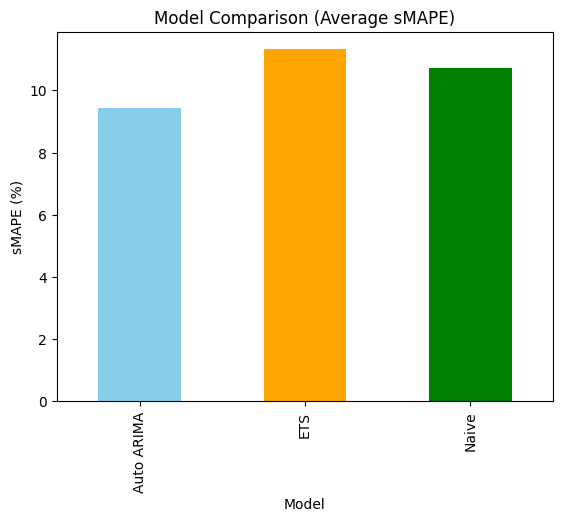

In [13]:
results_df = pd.DataFrame(results, columns=['Series', 'Category', 'Model', 'sMAPE'])

# Average sMAPE by model
avg_results = results_df.groupby('Model')['sMAPE'].mean()
print("Average sMAPE by Model:")
print(avg_results)

# Bar chart
avg_results.plot(kind='bar', title='Model Comparison (Average sMAPE)', color=['skyblue', 'orange', 'green'])
plt.ylabel('sMAPE (%)')
plt.savefig('model_comparison.png') 
plt.show()

Model     Auto ARIMA        ETS      Naive
Category                                  
Macro       9.425707  11.315915  10.723521


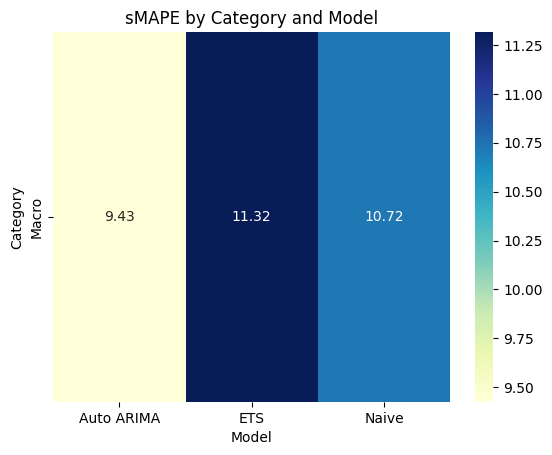

In [14]:
domain_results = results_df.groupby(['Category', 'Model'])['sMAPE'].mean().unstack()
print(domain_results)

sns.heatmap(domain_results, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title("sMAPE by Category and Model")
plt.savefig('category_heatmap.png')
plt.show()


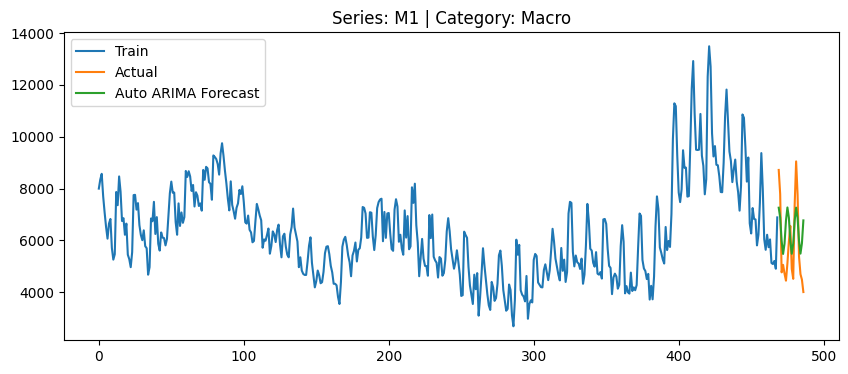

In [15]:
series_id = train_sample.iloc[0, 0]
series_values = train_sample.iloc[0, 1:].dropna().values
test_values = test_sample.iloc[0, 1:].dropna().values

model = auto_arima(series_values, seasonal=False, stepwise=True, suppress_warnings=True)
forecast = model.predict(n_periods=len(test_values))

category = info_sample[info_sample['M4id'] == series_id]['category'].values[0]

plt.figure(figsize=(10, 4))
plt.plot(range(len(series_values)), series_values, label='Train')
plt.plot(range(len(series_values), len(series_values)+len(test_values)), test_values, label='Actual')
plt.plot(range(len(series_values), len(series_values)+len(test_values)), forecast, label='Auto ARIMA Forecast')
plt.legend()
plt.title(f"Series: {series_id} | Category: {category}")
plt.savefig('example_forecast.png')
plt.show()

## Insights:
- Naive model gives the highest error (worst performance).
- Auto ARIMA usually performs the best but takes longer.
- ETS performs well for trend-based series.
- Category-wise performance shows which model is better for different domains.

## Next Steps:
- Add seasonal ARIMA (SARIMA) for seasonal patterns.
- Use larger sample (100+ series) for robust results.
- Try advanced models (Prophet, LSTM) for comparison.
